# Meet SALAD: Self-Adaptive Link Adaptation

SALAD (Self-Adaptation Link ADaptation) [[1]](#salad-ref) is an algorithm for adaptive
modulation and coding scheme in wireless networks.

It estimates the SINR by minimizing the cross-entropy loss between
the received ACK/NACK feedback and the corresponding BLER via gradient descent. 

When the SINR is deemed to be underestimated (based on a hypothesis
testing) SALAD increases the instantaneous BLER target to probe a higher MCS
value and corrects the SINR estimation accordingly. 

To meet a desired long-term BLER, SALAD adjusts the instantaneous BLER target
via a feedback loop. 

We show in a different notebook (["Knowledge Distillation"
notebook](salad_knowledge_distillation.ipynb)) how SALAD's learning rate can be adjusted
in an online fashion via knowledge distillation.

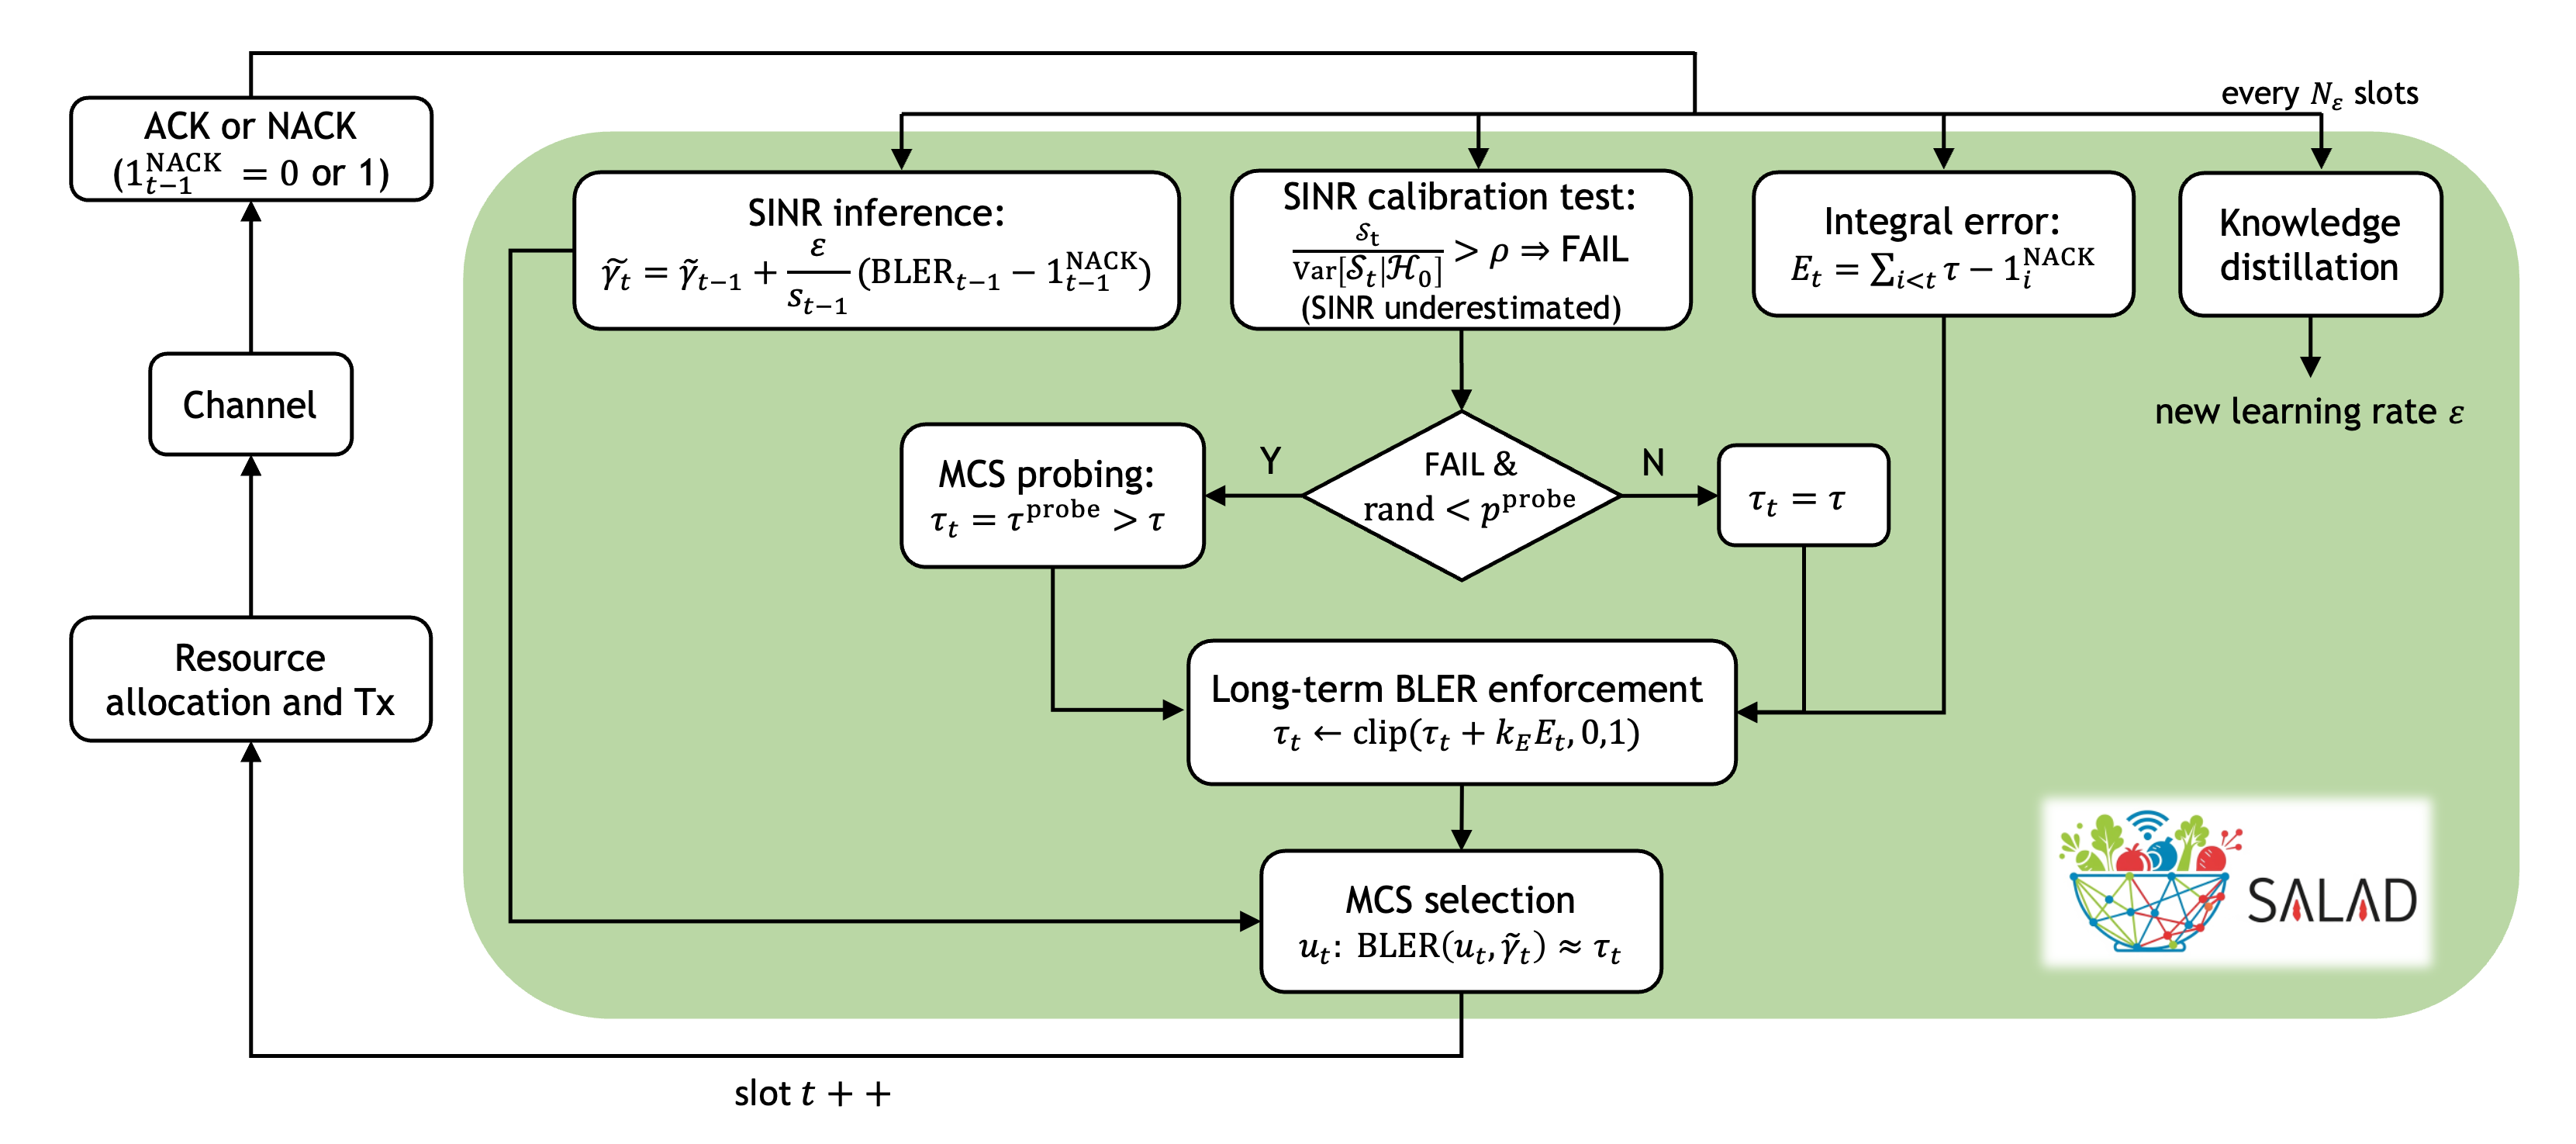


This notebook evaluates the performance of SALAD in the following setup:

- The SINR evolution over time is configurable;
- HARQ feedback, in the form of ACK/NACKs, is delayed and received in
  batches;
- SINR estimate reports from the user (called CQI reports in 5G-NR) are absent.

SALAD's performance is benchmarked against that of multiple variants of OLLA (Outer-Loop Link
Adaptation), the industry standard for link adaptation, as well as against an
oracle algorithm that has perfect knowledge of the SINR.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sys

sys.path.append('../')  # to access all relevant repo files

# LaTeX-style fonts for plots
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

from algos import SALAD, OLLA, ILLA
from utils import StudentSINREstimator, OLLASINREstimator, \
    run_la, rescale, get_bler_sigmoid_params, \
    generate_rect, generate_ar, plot_results
from config import BLER_FILENAME

# Fix random seed for reproducibility
np.random.seed(11)

## Simulation parameters

In [2]:
# Long-term BLER target (= average portion of NACKs)
bler_target = 0.1

# MCS table index
table_index = 2

# For simplicity, code block size is fixed throughout the simulation
cbs = 100

# N. slots to simulate
n_slots = 1000

# ACK/NACK are received in batch every `nack_report_batch_size` slots
nack_report_batch_size = 6

### BLER table

Load the BLER tables.

The SINR-vs-BLER curves are approximated by appropriate sigmoid functions. 
This speeds up simulation and allows for convenient analytical solutions for SALAD.

In [3]:
# Read BLER table
df = pd.read_csv('../' + BLER_FILENAME)

# Extract sigmoid parameters to approximate BLER tables
bler_sigmoid_params, min_available_mcs = \
    get_bler_sigmoid_params(df, cbs, table_index,
                            return_mcs_min_available=True)

# Spectral efficiency
mcs_to_se = df[(df['category'] == 'PDSCH') & (df['table_index'] == table_index) &
               (df['CBS_num_info_bits'] == cbs)]['spectral_efficiency'].values

## SINR time evolution

Configure the SINR evolution over time.

If `sinr_type=rect`, the SINR periodically switches abruptly between two states
and then remains constant. 

This is arguably the most challenging scenario for any link
adaptation algorithm, which should both adapt quickly to abrupt SINR changes and stabilize when the SINR remains constant.

In [4]:
# Lower / upper bounds of the SINR
sinr_bounds = [10, 25]

# Choose the SINR evolution type ('rect', 'ar', 'sin')
sinr_type = 'rect'

if sinr_type == 'rect':
    # Rectangular SINR evolution
    sinr_true = generate_rect(n_slots, n_jumps=2, bounds=sinr_bounds)
elif sinr_type == 'ar':
    # Autoregressive SINR evolution of order 1
    sinr_true = generate_ar(n_slots, coef=0.99, std_noise=.1, bounds=sinr_bounds)
elif sinr_type == 'sin':
    # Sinusoidal SINR evolution
    sinr_true = np.sin(2*np.pi*np.arange(n_slots)/200)
    sinr_true = rescale(sinr_true, sinr_bounds)
else:
    raise ValueError(f'Unknown SINR type: {sinr_type}')

Plot the SINR evolution over time

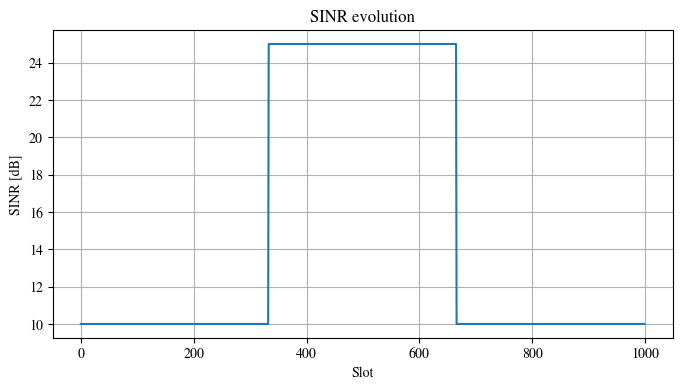

In [5]:
f, a = plt.subplots(1, 1, figsize=(8, 4))
a.plot(sinr_true)
a.grid()
a.set_title('SINR evolution')
a.set_xlabel('Slot')
a.set_ylabel('SINR [dB]')
plt.show()

## SALAD


Set SALAD's configuration parameters

In [6]:
# Bias score ratio threshold for MCS probing
rho_calibration = .25

# N. slots over which the bias score is computed
score_window = 15

# Prob(probing a high MCS index), if the bias score > rho_calibration
prob_probe = .15

# BLER target for probing
bler_target_probe = .95

# Integral gain
# The higher, the faster SALAD reacts to temporary BLER degradations 
k_e = .05

# Student's SINR estimator learning rate
# For simplicity, knowledge distillation is not considered in this notebook
learning_rate = 1.2

In [7]:
# Initial SINR estimation (for both OLLA and SALAD)
sinr_est_init = 10

Initialize SALAD

In [8]:
# Initialize student SINR estimator
sinr_estimator_salad = StudentSINREstimator(
    bler_sigmoid_params,
    sinr_init=sinr_est_init,
    learning_rate_init=learning_rate)

# Initialize SALAD
salad = SALAD(bler_target,
              bler_sigmoid_params,
              sinr_estimator_salad,
              rho_calibration=rho_calibration,
              prob_probe=prob_probe,
              bler_target_probe=bler_target_probe,
              k_e=k_e,
              score_window=score_window)

Run SALAD on the predefined SINR evolution and collect stats on MCS selection, ACK/NACK feedback, and achieved
spectral efficiency (SE).

In [9]:
is_nack_hist, rate_hist, la_algos, mcs_hist = {}, {}, {}, {}

is_nack_hist['SALAD'], rate_hist['SALAD'], la_algos['SALAD'], \
    mcs_hist['SALAD'] = \
    run_la(salad,
           sinr_true,
           bler_sigmoid_params,
           mcs_to_se=mcs_to_se,
           nack_report_batch_size=nack_report_batch_size)

## Benchmark: Outer-Loop Link Adaptation (OLLA)

Outer-Loop Link Adaptation (OLLA) is arguably the industry standard for link
adaptation since 3G [[2]](#olla-ref). 

OLLA estimates the SINR iteratively, by offsetting the previous estimation by a
fixed increment (`delta_ack`)  or decrement (`delta_nack`) depending on whether an ACK or a NACK is received. 
Then, the highest MCS index that does not exceed the BLER target is selected,
given the latest SINR estimation.

In [10]:
# List of delta_nack values for different OLLA variants.
# The higher delta_nack, the quicker the SINR adaptation but the less stable the
# MCS selection 
# Note: delta_ack is computed internally as bler_target * (1 - bler_target) * delta_nack
delta_nack_vec = [0.5, 1, 3]

Run the different OLLA variants on the predefined SINR evolution and collect stats on MCS selection, ACK/NACK feedback, and achieved
spectral efficiency (SE).

In [11]:
for delta_nack in delta_nack_vec:

    # Initialize OLLA's SINR estimator
    sinr_estimator_olla = OLLASINREstimator(
                bler_target,
                delta_nack=delta_nack,
                sinr_offset_init=sinr_est_init)

    # Initialize OLLA
    olla = OLLA(bler_target,
                bler_sigmoid_params,
                sinr_estimator_olla)

    # Run OLLA on the predefined SINR evolution
    lab = f'OLLA_delta_{delta_nack}'
    is_nack_hist[lab], rate_hist[lab], la_algos[lab], mcs_hist[lab] = \
        run_la(olla, sinr_true, bler_sigmoid_params, mcs_to_se=mcs_to_se,
               nack_report_batch_size=nack_report_batch_size)

### Oracle: Perfect SINR knowledge

Consider an oracle algorithm
that knows the SINR perfectly and computes the highest MCS which does not exceed the BLER target
at each slot.

Clearly, this oracle is not implementable in practice and provides a performance
upper bound for any link adaptation algorithm.

In [12]:
# Initialize ILLA (Inner-Loop Link Adaptation)
illa = ILLA(bler_target=bler_target,
            bler_sigmoid_params=bler_sigmoid_params)

# Compute the highest MCS index that does not exceed the BLER target on the true SINR
mcs_oracle = illa(sinr_true)

# Compute the achieved spectral efficiency
se_oracle = mcs_to_se[mcs_oracle] * (1 - bler_target)

## Plots

Benchmark SALAD with different OLLA variants, characterized by different
`delta_nack` offset parameters.

For each of the considered algorithm, we visualize the: 
- Instantaneous SINR estimation;
- MCS index selection;
- Achieved spectral efficiency (averaged over a sliding window);
- BLER (averaged over a sliding window and long-term average).

In [13]:
plot_only = None

# To only benchmark OLLA variants:
# plot_only = ['OLLA_delta_0.5', 'OLLA_delta_1', 'OLLA_delta_3']

# Define markers
markers = {'OLLA_delta_1': '',
           'OLLA_delta_0.5': '',
           'OLLA_delta_3': '',
           'SALAD': '*'}
# Define colors
colors = {'OLLA_delta_1': 'C0',
          'OLLA_delta_0.5': 'C1',
          'OLLA_delta_3': 'k',
          'SALAD': '#76B900'}

# Define linewidths
linewidths = {'OLLA_delta_1': 1,
              'OLLA_delta_0.5': 1,
              'OLLA_delta_3': 1,
              'SALAD': 1}

# Define legend names
legends = {'OLLA_delta_1': r"OLLA $\Delta^{\mathrm{NACK}}=1$",
           'OLLA_delta_0.5': r"OLLA $\Delta^{\mathrm{NACK}}=0.5$",
           'OLLA_delta_3': r"OLLA $\Delta^{\mathrm{NACK}}=3$",
           'SALAD': 'SALAD'}

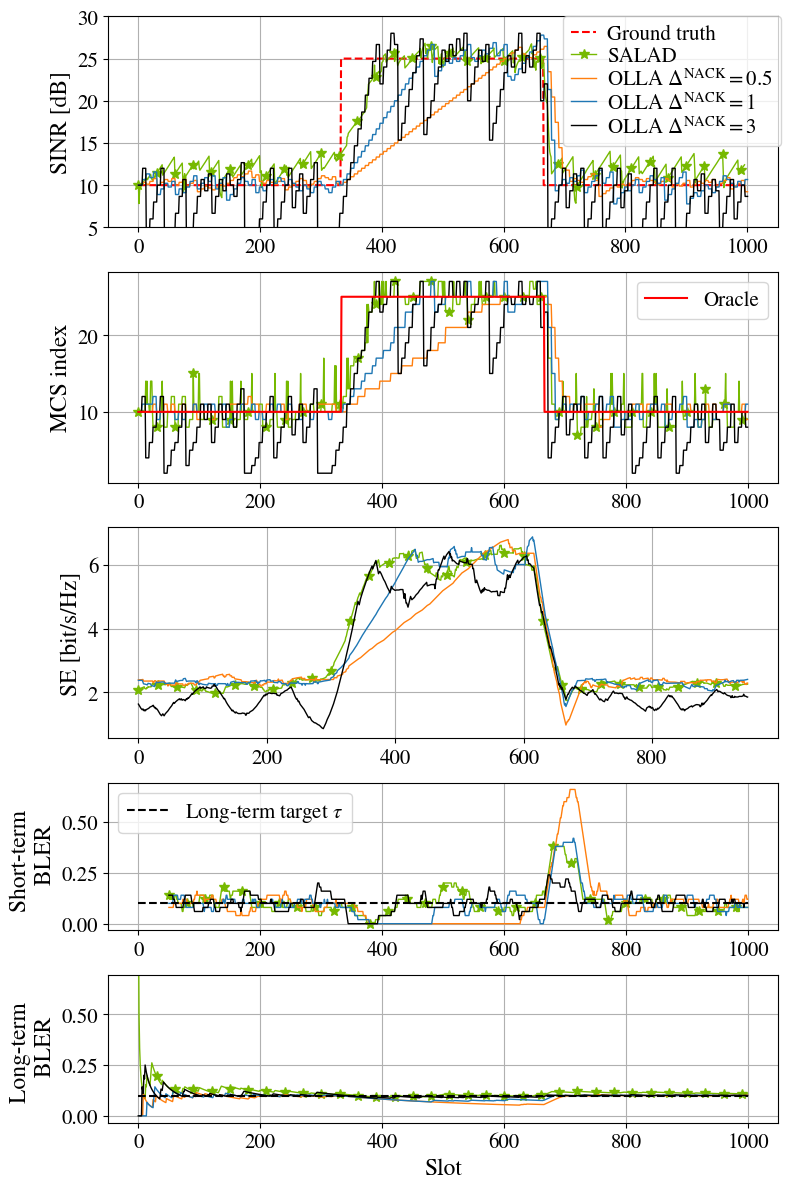

In [14]:
# Plot the results
fig = plot_results(sinr_true,
                   la_algos,
                   mcs_hist,
                   is_nack_hist,
                   rate_hist,
                   bler_target,
                   mcs_oracle=mcs_oracle,
                   min_available_mcs=min_available_mcs,
                   linewidths=linewidths,
                   legends=legends,
                   colors=colors,
                   markers=markers)

plt.show()

### References

<a id="salad-ref"></a>
**[1]** R. Wiesmayr, L. Maggi, S. Cammerer, F. Ait Aoudia, J. Hoydis, A. Keller,
"SALAD: Self-Adaptative Link Adaptation", arXiv, 2025

<a id="olla-ref"></a>
**[2]** K. I. Pedersen, G. Monghal, I. Z. Kovacs, T. E. Kolding, A. Pokhariyal, F.
Frederiksen, P. Mogensen. "Frequency domain scheduling for OFDMA with limited
and noisy channel feedback."," 2007 IEEE 66th Vehicular Technology Conference,
pp. 1792-1796, 2007. 